In [1]:
import librosa
import librosa.display
import IPython
import numpy as np
import pandas as pd
import scipy
import sklearn
import os
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import tensorflow as tf
import keras
from bs4 import BeautifulSoup
import requests
os.chdir('/content/drive/MyDrive/Senior Project Code/')

In [ ]:
!sudo apt-get install portaudio19-dev python-pyaudio
!pip3 install PyAudio
!pip3 install essentia

In [3]:
import numpy as np
import time
import essentia
from essentia.standard import *
import essentia.standard as es
import pandas as pd
import scipy
import sklearn
# librosa
import librosa
import librosa.display
import os
from os import listdir
from os.path import isfile, join, basename, splitext

def create_chroma_df(chroma):
	chroma_mean = np.mean(chroma, axis = 1)
	chroma_std = np.std(chroma, axis = 1)
	
	chroma_df = pd.DataFrame()
	for i in range(0,12):
		chroma_df['chroma ' + str(i) + ' mean'] = chroma_mean[i]
		chroma_df['chroma ' + str(i) + ' std'] = chroma_std[i]
	chroma_df.loc[0] = np.concatenate((chroma_mean, chroma_std), axis = 0)

	return chroma_df

def create_mfccs_df(mfccs):
	mfccs_mean = np.mean(mfccs, axis = 1)
	mfccs_std = np.std(mfccs, axis = 1)
   
	mfccs_df = pd.DataFrame()
	for i in range(0,13):
		mfccs_df['mfccs ' + str(i) + ' mean'] = mfccs_mean[i]
		mfccs_df['mfccs ' + str(i) + ' std'] = mfccs_std[i]
	mfccs_df.loc[0] = np.concatenate((mfccs_mean, mfccs_std), axis = 0)
	
	return mfccs_df

def create_rms_df(rms):
	rms_mean = np.mean(rms)
	rms_std = np.std(rms)
	rms_skew = scipy.stats.skew(rms, axis = 1)[0]
	
	rms_df = pd.DataFrame()
	rms_df['rms mean'] = rms_mean
	rms_df['rms std'] = rms_std
	rms_df['rms skew'] = rms_skew
	rms_df.loc[0] = np.concatenate((rms_mean, rms_std, rms_skew), axis = 0)
	
	return rms_df

def create_spectral_df(cent, contrast, rolloff, flatness):
	
	# spectral centroids values
	cent_mean = np.mean(cent)
	cent_std = np.std(cent)
	cent_skew = scipy.stats.skew(cent, axis = 1)[0]

	# spectral contrasts values
	contrast_mean = np.mean(contrast, axis = 1)
	contrast_std = np.std(contrast, axis = 1)
	
	# spectral rolloff points values
	rolloff_mean = np.mean(rolloff)
	rolloff_std = np.std(rolloff)
	rolloff_skew = scipy.stats.skew(rolloff, axis = 1)[0]
	
	# spectral flatness values
	flat_mean = np.mean(flatness)
	flat_std = np.std(flatness)
	flat_skew = scipy.stats.skew(flatness, axis = 1)[0]

	spectral_df = pd.DataFrame()
	collist = ['cent mean','cent std','cent skew',
			   'flat mean', 'flat std', 'flat skew',
			   'rolloff mean', 'rolloff std', 'rolloff skew']
	for i in range(0,7):
		collist.append('contrast ' + str(i) + ' mean')
		collist.append('contrast ' + str(i) + ' std')
	
	for c in collist:
		spectral_df[c] = 0
	data = np.concatenate((
		[cent_mean, cent_std, cent_skew], 
		[flat_mean, flat_std, flat_skew],
		[rolloff_mean, rolloff_std, rolloff_skew], 
		contrast_mean, contrast_std),
		axis = 0)
	spectral_df.loc[0] = data
	
	return spectral_df

def create_zrate_df(zrate):
	zrate_mean = np.mean(zrate)
	zrate_std = np.std(zrate)
	zrate_skew = scipy.stats.skew(zrate, axis = 1)[0]

	zrate_df = pd.DataFrame()
	zrate_df['zrate mean'] = 0
	zrate_df['zrate std'] = 0
	zrate_df['zrate skew'] = 0
	zrate_df.loc[0]=[zrate_mean, zrate_std, zrate_skew]
	
	return zrate_df


def create_beat_df(tempo):
	beat_df = pd.DataFrame()
	beat_df['tempo'] = tempo
	beat_df.loc[0] = tempo
	return beat_df
  
def extract_features(audio):
	y, sr = librosa.load(audio, sr=44100)
	y_harmonic = y
	#y_harmonic, y_percussive = librosa.effects.hpss(y)
	
	tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)
	beat_times = librosa.frames_to_time(beat_frames, sr=sr)
	beat_time_diff = np.ediff1d(beat_times)
	beat_nums = np.arange(1, np.size(beat_times))
	
	chroma = librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
	
	mfccs = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=13)
	
	cent = librosa.feature.spectral_centroid(y=y, sr=sr)
	
	flatness = librosa.feature.spectral_flatness(y=y)
	
	contrast = librosa.feature.spectral_contrast(y=y_harmonic,sr=sr)
	
	rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
	
	zrate = librosa.feature.zero_crossing_rate(y_harmonic)
	
	chroma_df = create_chroma_df(chroma)
	
	mfccs_df = create_mfccs_df(mfccs)
	
	spectral_df = create_spectral_df(cent, contrast, rolloff, flatness)
	
	zrate_df = create_zrate_df(zrate)
	
	beat_df = create_beat_df(tempo)
	
	final_df = pd.concat((chroma_df, mfccs_df, spectral_df, zrate_df, beat_df), axis = 1)
	
	return final_df

In [4]:
# from feature_extractors import *

features = extract_features('/content/drive/MyDrive/Senior Project Code/ClippedWavs/4065_chunk0.wav')

In [ ]:
!pip3 install ffmpeg-python

In [6]:
#https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio(name):
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))
  return audio, sr

In [274]:
audio, sr = get_audio("/content/drive/MyDrive/Senior Project Code/test_recording.wav")
scipy.io.wavfile.write("/content/drive/MyDrive/Senior Project Code/test_recording.wav", 44100, audio)

In [ ]:
!pip3 install pydub

In [ ]:
!pip3 install hmmlearn
!pip3 install simplejson
!pip3 install pyAudioAnalysis
!pip3 install eyed3


In [10]:
from pyAudioAnalysis import audioAnalysis

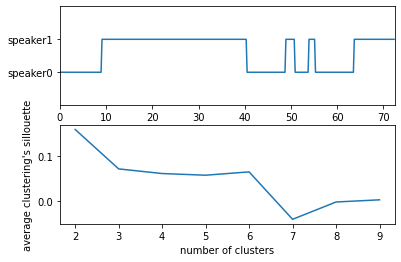

In [11]:
res = audioAnalysis.speakerDiarizationWrapper('/content/drive/MyDrive/Senior Project Code/ClippedWavs/4065_chunk0.wav', 0, 0)

In [236]:
import statistics
def db_to_float(db, using_amplitude=True):
    """
    Converts the input db to a float, which represents the equivalent
    ratio in power.
    """
    db = float(db)
    if using_amplitude:
        return 10 ** (db / 20)
    else:  # using power
        return 10 ** (db / 10)

def detect_silence(audio_segment, min_silence_len=1000, silence_thresh=-16, seek_step=1):
    """
    Returns a list of all silent sections [start, end] in milliseconds of audio_segment.
    Inverse of detect_nonsilent()
    audio_segment - the segment to find silence in
    min_silence_len - the minimum length for any silent section
    silence_thresh - the upper bound for how quiet is silent in dFBS
    seek_step - step size for interating over the segment in ms
    """
    seg_len = len(audio_segment)

    whole_segment_rms = audio_segment.rms

    # you can't have a silent portion of a sound that is longer than the sound
    if seg_len < min_silence_len:
        return []

    # convert silence threshold to a float value (so we can compare it to rms)
    dbfs_silence_thresh = db_to_float(silence_thresh) * audio_segment.max_possible_amplitude

    # find silence and add start and end indicies to the to_cut list
    silence_starts = []

    # check successive (1 sec by default) chunk of sound for silence
    # try a chunk at every "seek step" (or every chunk for a seek step == 1)
    last_slice_start = seg_len - min_silence_len
    slice_starts = range(0, last_slice_start + 1, seek_step)

    # guarantee last_slice_start is included in the range
    # to make sure the last portion of the audio is searched
    if last_slice_start % seek_step:
        slice_starts = itertools.chain(slice_starts, [last_slice_start])

    rms_of_each_segment = []
    for i in slice_starts:
        audio_slice = audio_segment[i:i + min_silence_len]
        rms_of_each_segment.append(audio_slice.rms)
    rms_standard_deviation = statistics.stdev(rms_of_each_segment)

    for i in slice_starts:
        audio_slice = audio_segment[i:i + min_silence_len]
        if audio_slice.rms <= dbfs_silence_thresh or audio_slice.rms <= (whole_segment_rms - 2*rms_standard_deviation):
            silence_starts.append(i)

    # short circuit when there is no silence
    if not silence_starts:
        return []

    # combine the silence we detected into ranges (start ms - end ms)
    silent_ranges = []

    prev_i = silence_starts.pop(0)
    current_range_start = prev_i

    for silence_start_i in silence_starts:
        continuous = (silence_start_i == prev_i + seek_step)

        # sometimes two small blips are enough for one particular slice to be
        # non-silent, despite the silence all running together. Just combine
        # the two overlapping silent ranges.
        silence_has_gap = silence_start_i > (prev_i + min_silence_len)

        if not continuous and silence_has_gap:
            silent_ranges.append([current_range_start,
                                  prev_i + min_silence_len])
            current_range_start = silence_start_i
        prev_i = silence_start_i

    silent_ranges.append([current_range_start,
                          prev_i + min_silence_len])

    return silent_ranges

In [237]:
from pydub import AudioSegment, silence
from scipy.io.wavfile import read as wav_read
from statistics import mean

def get_intervals_of_silence(audio, silence_thresh=-25):
  silence_intervals = detect_silence(audio, min_silence_len=1000, silence_thresh=silence_thresh)
  silence_intervals = [((start/1000),(stop/1000)) for start,stop in silence_intervals] #convert to sec
  return silence_intervals

def get_silence_info(audio, silence_thresh=-25):
  audio = AudioSegment.from_wav(audio)
  silence_intervals = get_intervals_of_silence(audio, silence_thresh)
  silence_info = {}
  silence_info['intervals'] = silence_intervals
  silence_info['durations'] = [y - x for x, y in silence_intervals]
  silence_info['max_silence'] = max(silence_info['durations'])
  silence_info['min_silence'] = min(silence_info['durations'])
  silence_info['avg_silence'] = mean(silence_info['durations'])
  silence_info['frequency'] = len(silence_info['durations'])
  silence_info['total_silence'] = sum(silence_info['durations'])
  silence_info['silence_ratio'] = silence_info['total_silence']/(len(audio)/1000)
  return silence_info

In [191]:
silence_intervals = get_intervals_of_silence('/content/drive/MyDrive/Senior Project Code/test_recording.wav')

In [238]:
get_silence_info('/content/drive/MyDrive/Senior Project Code/test_recording.wav', -50)

{'avg_silence': 1.8639999999999999,
 'durations': [1.689, 2.358, 2.295, 1.1139999999999999],
 'frequency': 4,
 'intervals': [(0.0, 1.689), (1.799, 4.157), (4.158, 6.453), (6.832, 7.946)],
 'max_silence': 2.358,
 'min_silence': 1.1139999999999999,
 'silence_ratio': 0.9383337528316135,
 'total_silence': 7.456}

In [234]:
sound = AudioSegment.from_file("/content/drive/MyDrive/Senior Project Code/test_recording.wav", '.wav')
print(sound.dBFS)
print(sound.max_dBFS)
print(sound.rms)

-42.7410406802316
-15.927347221164638
239


In [39]:
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

sound = AudioSegment.from_file("/content/drive/MyDrive/Senior Project Code/test_recording.wav", '.wav')
normalized_sound = match_target_amplitude(sound, 30)
# normalized_sound.export("new_test.wav", format="wav")

<_io.BufferedRandom name='new_test.wav'>

In [ ]:
!pip3 install resemblyzer
!pip3 install spectralcluster

In [319]:
from scipy.ndimage.morphology import binary_dilation
from resemblyzer.hparams import *
from pathlib import Path
from typing import Optional, Union
import numpy as np
import webrtcvad
import librosa
import struct

int16_max = (2 ** 15) - 1


def preprocess_wav(fpath_or_wav: Union[str, Path, np.ndarray], source_sr: Optional[int]=None):
    """
    Applies preprocessing operations to a waveform either on disk or in memory such that  
    The waveform will be resampled to match the data hyperparameters.
    :param fpath_or_wav: either a filepath to an audio file (many extensions are supported, not 
    just .wav), either the waveform as a numpy array of floats.
    :param source_sr: if passing an audio waveform, the sampling rate of the waveform before 
    preprocessing. After preprocessing, the waveform'speaker sampling rate will match the data 
    hyperparameters. If passing a filepath, the sampling rate will be automatically detected and 
    this argument will be ignored.
    """
    # Load the wav from disk if needed
    if isinstance(fpath_or_wav, str) or isinstance(fpath_or_wav, Path):
        wav, source_sr = librosa.load(str(fpath_or_wav), sr=None)
    else:
        wav = fpath_or_wav
    
    # Resample the wav
    if source_sr is not None:
        wav = librosa.resample(wav, source_sr, sampling_rate)
        
    # Apply the preprocessing: normalize volume and shorten long silences 
    wav = normalize_volume(wav, audio_norm_target_dBFS, increase_only=True)
    wav = trim_long_silences(wav)
    
    return wav

def trim_long_silences(wav):
    """
    Ensures that segments without voice in the waveform remain no longer than a 
    threshold determined by the VAD parameters in params.py.
    :param wav: the raw waveform as a numpy array of floats 
    :return: the same waveform with silences trimmed away (length <= original wav length)
    """
    # Compute the voice detection window size
    samples_per_window = (vad_window_length * sampling_rate) // 1000
    
    # Trim the end of the audio to have a multiple of the window size
    wav = wav[:len(wav) - (len(wav) % samples_per_window)]
    
    # Convert the float waveform to 16-bit mono PCM
    pcm_wave = struct.pack("%dh" % len(wav), *(np.round(wav * int16_max)).astype(np.int16))
    
    # Perform voice activation detection
    voice_flags = []
    vad = webrtcvad.Vad(mode=3)
    for window_start in range(0, len(wav), samples_per_window):
        window_end = window_start + samples_per_window
        voice_flags.append(vad.is_speech(pcm_wave[window_start * 2:window_end * 2],
                                         sample_rate=sampling_rate))
    voice_flags = np.array(voice_flags)
    
    # Smooth the voice detection with a moving average
    def moving_average(array, width):
        array_padded = np.concatenate((np.zeros((width - 1) // 2), array, np.zeros(width // 2)))
        ret = np.cumsum(array_padded, dtype=float)
        ret[width:] = ret[width:] - ret[:-width]
        return ret[width - 1:] / width
    
    audio_mask = moving_average(voice_flags, vad_moving_average_width)
    audio_mask = np.round(audio_mask).astype(np.bool)
    
    # Dilate the voiced regions
    audio_mask = binary_dilation(audio_mask, np.ones(vad_max_silence_length + 1))
    audio_mask = np.repeat(audio_mask, samples_per_window)
    print(wav, len(wav))
    print(wav[audio_mask == True], len(wav[audio_mask == True]))
    print(wav[audio_mask == False], len(wav[audio_mask == False]))
    return wav[audio_mask == True]

def normalize_volume(wav, target_dBFS, increase_only=False, decrease_only=False):
    if increase_only and decrease_only:
        raise ValueError("Both increase only and decrease only are set")
    rms = np.sqrt(np.mean((wav * int16_max) ** 2))
    wave_dBFS = 20 * np.log10(rms / int16_max)
    dBFS_change = target_dBFS - wave_dBFS
    if dBFS_change < 0 and increase_only or dBFS_change > 0 and decrease_only:
        return wav
    return wav * (10 ** (dBFS_change / 20))

In [318]:
#https://medium.com/saarthi-ai/who-spoke-when-build-your-own-speaker-diarization-module-from-scratch-e7d725ee279
# from resemblyzer import  preprocess_wav, VoiceEncoder
from pathlib import Path
from spectralcluster import SpectralClusterer
import librosa

def generate_embeddings(audio):
  #give the file path to your audio file
  audio_file_path = audio
  wav_fpath = Path(audio_file_path)
  lib_wav, sr = librosa.load(audio)
  wav = preprocess_wav(wav_fpath)
  encoder = VoiceEncoder("cpu")
  _, cont_embeds, wav_splits = encoder.embed_utterance(wav, return_partials=True, rate=16)
  print(cont_embeds.shape)
  return cont_embeds, wav_splits

def spectral_cluster_predict(cont_embeds):
  clusterer = SpectralClusterer(
      min_clusters=2,
      max_clusters=100,
      p_percentile=0.90,
      gaussian_blur_sigma=1)

  labels = clusterer.predict(cont_embeds)
  return labels

def create_labelling(labels,wav_splits):
    from resemblyzer import hparams
    times = [((s.start + s.stop) / 2) / hparams.sampling_rate for s in wav_splits]
    print(wav_splits)
    print(times)
    labelling = []
    start_time = 0

    for i,time in enumerate(times):
        if i>0 and labels[i]!=labels[i-1]:
            temp = [str(labels[i-1]),start_time,time]
            labelling.append(tuple(temp))
            start_time = time
        if i==len(times)-1:
            temp = [str(labels[i]),start_time,time]
            labelling.append(tuple(temp))

    return labelling

def wav_file_diarization(audio):
  cont_embeds, wav_splits = generate_embeddings(audio)
  labels = spectral_cluster_predict(cont_embeds)
  labelling = create_labelling(labels, wav_splits)
  return labelling

In [317]:
# labelling = wav_file_diarization('/content/drive/MyDrive/Senior Project Code/ClippedWavs/4065_chunk0.wav')
labelling = wav_file_diarization('/content/drive/MyDrive/Senior Project Code/test_recording.wav')

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.3572947e-03
 -7.3282141e-04  5.0479698e-06] 96960
[-4.1465632e-05 -5.7640823e-04 -9.7144261e-04 ...  1.7129695e-03
  1.4860412e-03  1.2780729e-03] 32640
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.3572947e-03
 -7.3282141e-04  5.0479698e-06] 64320
Loaded the voice encoder model on cpu in 0.01 seconds.
(9, 256)
[slice(0, 25600, None), slice(960, 26560, None), slice(1920, 27520, None), slice(2880, 28480, None), slice(3840, 29440, None), slice(4800, 30400, None), slice(5760, 31360, None), slice(6720, 32320, None), slice(7680, 33280, None)]
[0.8, 0.86, 0.92, 0.98, 1.04, 1.1, 1.16, 1.22, 1.28]


In [311]:
print(labelling)
zero = sum([1 for x in labelling if x[0] == '0'])
one = sum([1 for x in labelling if x[0] == '1'])
print(zero)
print(one)

[('0', 0, 1.28), ('1', 1.28, 2.66), ('0', 2.66, 4.16), ('1', 4.16, 5.42), ('0', 5.42, 7.58)]
3
2


In [254]:
audio = '/content/drive/MyDrive/Senior Project Code/test_recording.wav'
audio_file_path = audio
wav_fpath = Path(audio_file_path)
lib_wav, sr = librosa.load(audio)
wav = preprocess_wav(wav_fpath)
encoder = VoiceEncoder("cpu")
_, cont_embeds, wav_splits = encoder.embed_utterance(wav, return_partials=True, rate=16)
print(len(wav_splits))
print(len(lib_wav), sr)

Loaded the voice encoder model on cpu in 0.01 seconds.
31
75807 22050


In [87]:
wav, sr = librosa.load('/content/drive/MyDrive/Senior Project Code/test_recording.wav')
print(wav, len(wav))
wav = preprocess_wav('/content/drive/MyDrive/Senior Project Code/test_recording.wav')
print(wav, len(wav))
scipy.io.wavfile.write("/content/drive/MyDrive/Senior Project Code/test_recording_preproc.wav", 44100, wav)

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.7599545e-04
  1.3516725e-04  4.5803445e-05] 141287
[0.00747681 0.00779724 0.00787354 ... 0.00257874 0.00190735 0.00123596] 199200


In [ ]:
!pip3 install -q pyannote.audio==1.1

In [243]:
from pyannote.audio.features import RawAudio
from pyannote.core import Segment, notebook
from IPython.display import Audio
import google.colab
# own_file, _ = google.colab.files.upload().popitem()
OWN_FILE = {'audio': '/content/drive/MyDrive/Senior Project Code/ClippedWavs/4065_chunk0.wav'}
notebook.reset()

waveform = RawAudio(sample_rate=16000)(OWN_FILE).data
Audio(data=waveform.squeeze(), rate=16000, autoplay=True)

import torch
pipeline = torch.hub.load('pyannote/pyannote-audio', 'dia')
diarization = pipeline(OWN_FILE)

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master
/usr/local/lib/python3.7/dist-packages/pyannote/audio/embedding/approaches/arcface_loss.py:170: FutureWarning:

The 's' parameter is deprecated in favor of 'scale', and will be removed in a future release

/usr/local/lib/python3.7/dist-packages/pyannote/audio/features/pretrained.py:156: UserWarning:

Model was trained with 4s chunks and is applied on 2s chunks. This might lead to sub-optimal results.

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_master


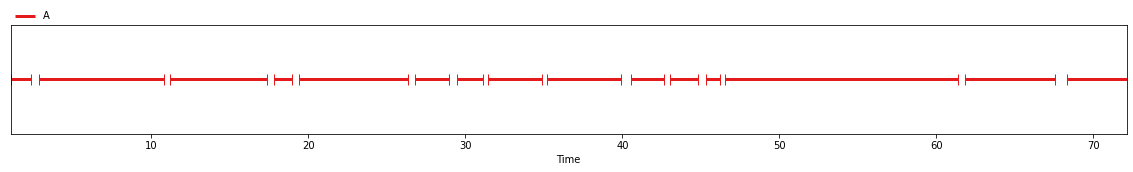

In [244]:
diarization